In [1]:
import argparse
import torch
import dill as pickle
from model import LegalQAClassifier
from utils import str2bool
from preprocess import annotate, to_id, init
from train import BatchGen

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
%matplotlib inline

import sys
sys.argv = ['foo'] # argparse issue with iPython

In [2]:
parser = argparse.ArgumentParser(description='Interact with LegalQA classifier.')
parser.add_argument('--model-file', default='models/best_model.pt')
parser.add_argument("--cuda", type=str2bool, nargs='?',
                    const=True, default=torch.cuda.is_available(),
                    help='whether to use GPU acceleration.')
parser.add_argument('--meta_file', default='coliee_meta_full.msgpack')
args = parser.parse_args()

In [3]:
if args.cuda:
    checkpoint = torch.load(args.model_file)
else:
    checkpoint = torch.load(args.model_file, map_location=lambda storage, loc: storage)

state_dict = checkpoint['state_dict']
opt = checkpoint['config']
with open(args.meta_file, 'rb') as f:
    meta = pickle.load(f)

In [4]:
embedding = torch.Tensor(meta['embedding'])
opt['pretrained_words'] = True
opt['vocab_size'] = embedding.size(0)
opt['embedding_dim'] = embedding.size(1)
opt['pos_size'] = len(meta['vocab_tag'])
opt['ner_size'] = len(meta['vocab_ent'])
opt['cuda'] = args.cuda
opt['classes'] = {'Y': 0, 'N': 1}
opt['id_classes'] = {0: 'Yes', 1: 'No'}
opt['interact'] = True
BatchGen.pos_size = opt['pos_size']
BatchGen.ner_size = opt['ner_size']
model = LegalQAClassifier(opt, embedding, state_dict)
w2id = {w: i for i, w in enumerate(meta['vocab'])}
tag2id = {w: i for i, w in enumerate(meta['vocab_tag'])}
ent2id = {w: i for i, w in enumerate(meta['vocab_ent'])}
init()

In [5]:
def interact_entailment(article, query):
    annotated = annotate(('interact-entailment', article, query, 'Y'))
    model_in = to_id(annotated, w2id, tag2id, ent2id)
    model_in = next(iter(BatchGen([model_in], opt, batch_size=1, gpu=args.cuda, evaluation=True)))
    prediction, values = model.interact_(model_in)

    max_probs = torch.max(prediction, 1)[1].item()
    probs = prediction[0].tolist()
    print('Answer: {0}, with probability Yes: {1:.4f}%, and No: {2:.4f}%'
          .format(opt['id_classes'][max_probs], probs[0] * 100, probs[1] * 100))
    
    return annotated[1], annotated[5], values # article, query, values

In [6]:
def plot_alignment_matrix(values, query, article):
    fig, ax = plt.subplots(figsize=(20, 15)) # figsize=(width, height)
    sns.heatmap(values, annot=True, ax=ax)
    plt.xlabel("Query tokens")
    plt.ylabel("Article tokens")
    
    # Set up axes
    ax.set_xticklabels([''] + article, rotation=90)
    ax.set_yticklabels([''] + query, rotation=0)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

In [8]:
article = "A will may not be made by two or more persons on the same certificate."
query   = "A husband and wife may make their will on the same certificate."
article_list, query_list, values  = interact_entailment(article, query)

Answer: No, with probability Yes: 2.0309%, and No: 99.0591%


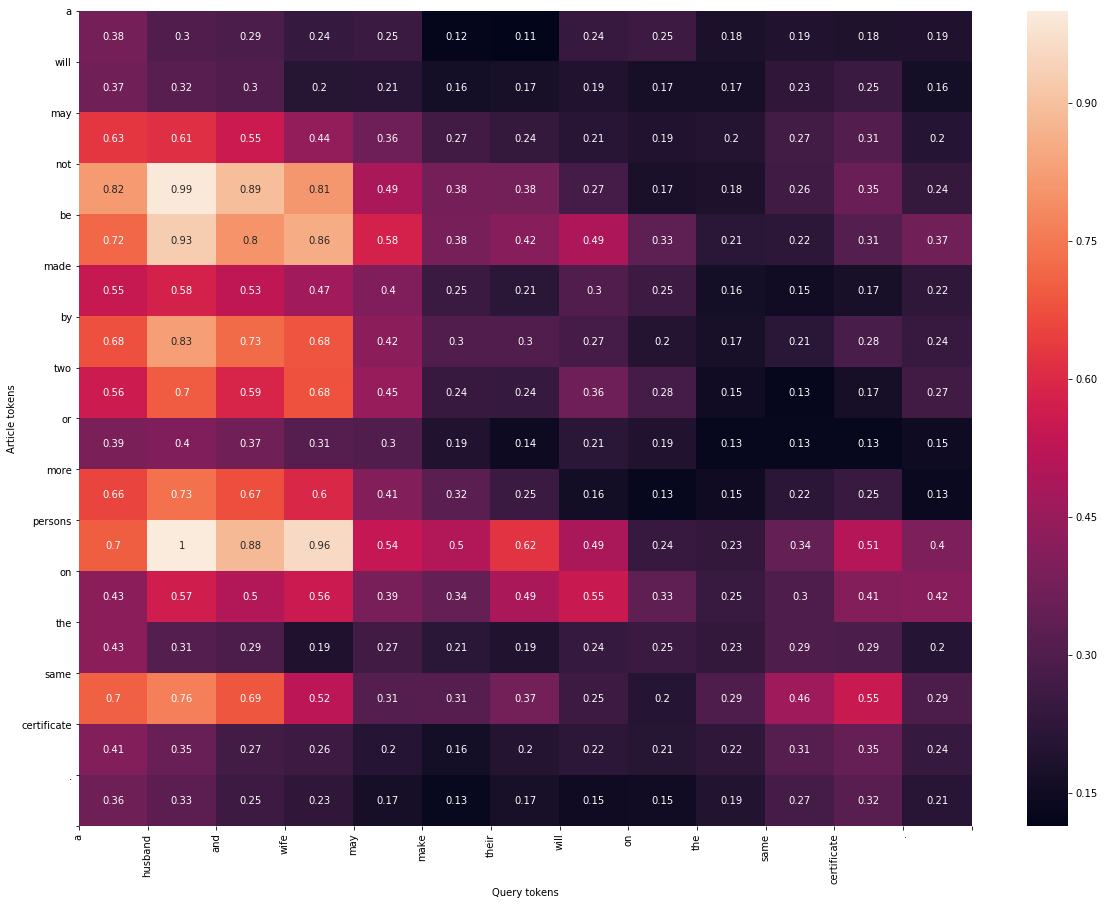

In [9]:
plot_alignment_matrix(values, article_list, query_list)